Authors : Abishek Gollapudi, Zoey Herm, Max Staley

In [0]:
#!pip install geopandas

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
#import geopandas as gpd
#from geopandas.tools import geocode

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [0]:
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

df = df1.append([df2, df3])


In [0]:
df.head()


C/A  ... EXITS                                                               
0  A002  ...                                            2382234                  
1  A002  ...                                            2382240                  
2  A002  ...                                            2382269                  
3  A002  ...                                            2382335                  
4  A002  ...                                            2382395                  

[5 rows x 11 columns]

In [0]:
# Data Cleaning 

df.columns = df.columns.str.strip()

df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format="%m/%d/%Y %H:%M:%S")

#df.drop(columns=['DATE', 'TIME'], inplace=True)

df['DAY'] = df['DATETIME'].dt.day_name()

df.to_pickle("main.pkl")

# Each turnstile can be indentified by a combination of the UNIT and SCP. Grouping by these two features allows us to get accurate
# entry and exit counts. 

df['ENTRY COUNT'] = df.groupby(['UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff())
df['EXIT COUNT'] = df.groupby(['UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff())


In [0]:
df.head()

C/A  UNIT       SCP  ...       DAY ENTRY COUNT EXIT COUNT
0  A002  R051  02-00-00  ...  Saturday         NaN        NaN
1  A002  R051  02-00-00  ...  Saturday        17.0        6.0
2  A002  R051  02-00-00  ...  Saturday        18.0       29.0
3  A002  R051  02-00-00  ...  Saturday        77.0       66.0
4  A002  R051  02-00-00  ...  Saturday       193.0       60.0

[5 rows x 15 columns]

In [0]:
df.describe()

ENTRIES         EXITS   ENTRY COUNT    EXIT COUNT
count  6.148020e+05  6.148020e+05  6.099380e+05  6.099380e+05
mean   4.084381e+07  3.341919e+07  9.933010e+02  1.860043e+03
std    2.096598e+08  1.933731e+08  3.364400e+06  3.064132e+06
min    0.000000e+00  0.000000e+00 -1.835264e+09 -1.359348e+09
25%    3.494502e+05  1.438178e+05  9.000000e+00  8.000000e+00
50%    2.174896e+06  1.244878e+06  7.000000e+01  5.100000e+01
75%    6.773246e+06  4.590770e+06  2.330000e+02  1.620000e+02
max    2.129355e+09  2.124143e+09  1.126553e+09  1.078346e+09

Both **ENTRY COUNT** AND **EXIT COUNT** have negative values and for the min and crazy high values for the max. This is in part due to complications such as turnstiles being reset, changed, etc.

In [0]:
# Dropping rows with irrational values

df = df[(df['ENTRY COUNT'] >= 0) & (df['EXIT COUNT'] >= 0)]

In [0]:
Q1_entry = df['ENTRY COUNT'].quantile(0.25)
Q3_entry = df['ENTRY COUNT'].quantile(0.75)
IQR_entry = Q3_entry - Q1_entry

Q1_exit = df['EXIT COUNT'].quantile(0.25)
Q3_exit = df['EXIT COUNT'].quantile(0.75)
IQR_exit = Q3_exit - Q1_exit

entry_bound = Q3_entry + 1.5 * IQR_entry
exit_bound = Q3_exit + 1.5 * IQR_exit

In [0]:
df.describe()

ENTRIES         EXITS   ENTRY COUNT    EXIT COUNT
count  6.026730e+05  6.026730e+05  6.026730e+05  6.026730e+05
mean   2.786367e+07  2.016885e+07  6.446536e+03  6.742399e+03
std    1.588909e+08  1.360172e+08  2.110708e+06  2.269092e+06
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    3.366980e+05  1.389650e+05  1.000000e+01  8.000000e+00
50%    2.121450e+06  1.207749e+06  7.200000e+01  5.100000e+01
75%    6.466613e+06  4.418113e+06  2.350000e+02  1.640000e+02
max    2.115823e+09  2.037820e+09  1.126553e+09  1.078346e+09

In [0]:
IQR_df = df.copy()
IQR_df = df[(df['ENTRY COUNT'] < entry_bound) & (df['EXIT COUNT'] < exit_bound)]
ax = sns.boxplot(data=IQR_df[['EXIT COUNT', 'ENTRY COUNT']])

In [0]:
df = df[(df['ENTRY COUNT'] < 15000 ) & (df['EXIT COUNT'] < 15000)]
df.describe()

ENTRIES         EXITS    ENTRY COUNT     EXIT COUNT
count  6.026360e+05  6.026360e+05  602636.000000  602636.000000
mean   2.785908e+07  2.016344e+07     172.095854     135.882961
std    1.588826e+08  1.360033e+08     251.462361     233.056615
min    0.000000e+00  0.000000e+00       0.000000       0.000000
25%    3.367968e+05  1.389408e+05      10.000000       8.000000
50%    2.121494e+06  1.207656e+06      72.000000      51.000000
75%    6.466618e+06  4.417960e+06     235.000000     164.000000
max    2.115823e+09  2.037820e+09   13759.000000    9407.000000

In [0]:
final = df.groupby(['STATION', 'LINENAME']).agg({'ENTRY COUNT' : 'sum', 'EXIT COUNT' : 'sum'})
final.reset_index(inplace=True)
final['TOTAL TRAFFIC'] = final['ENTRY COUNT'] + final['EXIT COUNT']
top = final.sort_values('EXIT COUNT', ascending=False).head(10)
top

STATION      LINENAME  ENTRY COUNT  EXIT COUNT  TOTAL TRAFFIC
311  GRD CNTRL-42 ST         4567S    2639828.0   2326228.0      4966056.0
89   34 ST-HERALD SQ      BDFMNQRW    2129151.0   2011772.0      4140923.0
93    34 ST-PENN STA           ACE    1527514.0   1383212.0      2910726.0
102  42 ST-PORT AUTH  ACENQRS1237W    1439824.0   1209977.0      2649801.0
446   TIMES SQ-42 ST  1237ACENQRSW    1261544.0   1207689.0      2469233.0
27    14 ST-UNION SQ      LNQR456W    1330276.0   1199564.0      2529840.0
106   47-50 STS ROCK          BDFM    1064730.0   1099616.0      2164346.0
301        FULTON ST      2345ACJZ    1103759.0   1089165.0      2192924.0
125   59 ST COLUMBUS         ABCD1    1099081.0    908617.0      2007698.0
402     PATH NEW WTC             1     956183.0    864703.0      1820886.0

# Rush hour analysis to find commuter stations

In [0]:
df_cp = df.copy()

In [0]:
df = pd.read_pickle("main.pkl")

df = df[(df["DAY"] != 'Saturday') & (df["DAY"] != 'Sunday')]


In [0]:

df = df[(df['DESC'] == 'REGULAR')] 
del df['C/A']
del df['LINENAME']
del df['DIVISION']
del df['DESC']


In [0]:
# make a new column where times between:
# 8 AM (inclusive) and 12 PM (exclusive) = morning
# 12 PM (inclusive) and 4 PM (exclusive) = midday
# 4 PM (inclusive) and 8 PM (exclusive) = evening

# start by making a function
def time_bin(time):
    if time >= '04:00:00' and time <= '06:00:00':
        return 'early'
    if time >= '06:00:00' and time <= '12:00:00':
        return 'morning'
    if time >= '12:00:00' and time <= '16:00:00':
        return 'midday'
    if time >= '16:00:00' and time <= '20:00:00':
        return 'evening'
    if time >= '20:00:00' and time <= '24:00:00':
        return 'night'
# then use apply to make a new column according to that function
df['time_bin'] = df['TIME'].apply(lambda row: time_bin(row))

# drop rows that don't fall within one of those bins
df = df[(df['time_bin'].notnull())] 

df.sort_values(['UNIT', 'SCP', 'DATETIME'], ascending=True, inplace = True)


In [0]:
# Find the differences in commuters by subtracting each row from it's preceeding row
# for exits and entries, and then combine the two for a total traffic column

df.sort_values(['UNIT', 'SCP', 'DATETIME'], ascending=True, inplace = True)

df['exits_diff'] = df.groupby(['UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff())
df['entries_diff'] = df.groupby(['UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff())
df['total_diff'] = df['entries_diff'] + df['exits_diff']


df = df[(df['exits_diff'] > 0)] 
df = df[(df['exits_diff'] < 15000)] 

df = df[(df['entries_diff'] > 0)] 
df = df[(df['entries_diff'] < 15000)] 


df = df[(df['total_diff'] > 0)] 
df = df[(df['total_diff'] < 15000)]

In [0]:
len(df)

ENTRIES         EXITS     exits_diff   entries_diff     total_diff
count  3.104170e+05  3.104170e+05  310417.000000  310417.000000  310417.000000
mean   2.679441e+07  1.992665e+07     245.651997     314.745175     560.397172
std    1.579042e+08  1.338087e+08     396.558049     418.886089     677.953795
min    2.000000e+00  7.000000e+00       1.000000       1.000000       2.000000
25%    6.300330e+05  3.484210e+05      49.000000      77.000000     192.000000
50%    2.682619e+06  1.577697e+06     126.000000     195.000000     394.000000
75%    6.869065e+06  4.924841e+06     290.000000     407.000000     714.000000
max    2.115823e+09  2.037820e+09   11792.000000   10684.000000   14877.000000

In [0]:
# Make a column that shows the time elapsed between data points

df['entries_time_diff'] = df.groupby(['UNIT', 'SCP', 'DAY'])['DATETIME'].transform(lambda x: x.diff())

df = df[(df['entries_time_diff'].notnull())] 
print(df.info())
print(df.entries_time_diff.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 288921 entries, 10568 to 112933
Data columns (total 14 columns):
UNIT                 288921 non-null object
SCP                  288921 non-null object
STATION              288921 non-null object
DATE                 288921 non-null object
TIME                 288921 non-null object
ENTRIES              288921 non-null int64
EXITS                288921 non-null int64
DATETIME             288921 non-null datetime64[ns]
DAY                  288921 non-null object
time_bin             288921 non-null object
exits_diff           288921 non-null float64
entries_diff         288921 non-null float64
total_diff           288921 non-null float64
entries_time_diff    288921 non-null timedelta64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(7), timedelta64[ns](1)
memory usage: 33.1+ MB
None
count                    288921
mean     1 days 01:44:30.592158
std      2 days 04:48:44.723515
min             0 days 00:00:03
25%             

In [0]:

df = df[(df['entries_time_diff'] < '0 days 23:00:00') & (df['entries_time_diff'] > '0 days 00:00:00')]

print(df.entries_time_diff.describe())
print(df.info())
df.head()

count                    246687
mean     0 days 03:57:28.795583
std      0 days 00:42:51.650483
min             0 days 00:00:03
25%             0 days 04:00:00
50%             0 days 04:00:00
75%             0 days 04:00:00
max             0 days 18:17:50
Name: entries_time_diff, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 246687 entries, 10568 to 112933
Data columns (total 17 columns):
UNIT                  246687 non-null object
SCP                   246687 non-null object
STATION               246687 non-null object
DATE                  246687 non-null object
TIME                  246687 non-null object
ENTRIES               246687 non-null int64
EXITS                 246687 non-null int64
DATETIME              246687 non-null datetime64[ns]
DAY                   246687 non-null object
time_bin              246687 non-null object
exits_diff            246687 non-null float64
entries_diff          246687 non-null float64
total_diff            246687 non-null floa

UNIT       SCP  ... normalized_exits normalized_entries
10568  R001  00-00-00  ...        14.236111             146.25
10569  R001  00-00-00  ...        17.777778             165.75
10570  R001  00-00-00  ...        23.680556             131.50
10573  R001  00-00-00  ...         7.152778             210.25
10574  R001  00-00-00  ...        12.708333             149.25

[5 rows x 17 columns]

In [0]:
df['seconds'] = df['entries_time_diff'].dt.seconds
df['normalized_exits'] = df['exits_diff'] / df['seconds'] * 1000
df['normalized_entries'] = df['entries_diff'] / df['seconds'] * 60 * 60
print(df.normalized_entries.describe())

df2 = df[['STATION', 'time_bin', 'normalized_entries', 'normalized_exits']].copy()



count    246687.000000
mean         80.338990
std          78.755869
min           0.059524
25%          25.500000
50%          57.250000
75%         110.500000
max        3600.000000
Name: normalized_entries, dtype: float64


In [0]:
am_agg_exit = df2[(df2['time_bin'] == 'morning')].groupby(['STATION']).agg({'normalized_exits' : 'sum'})
mid_agg_exit = df2[(df2['time_bin'] == 'midday')].groupby(['STATION']).agg({'normalized_exits' : 'sum'})
mid_agg_entry = df2[(df2['time_bin'] == 'midday')].groupby(['STATION']).agg({'normalized_entries' : 'sum'})
pm_agg_entry = df2[(df2['time_bin'] == 'evening')].groupby(['STATION']).agg({'normalized_entries' : 'sum'})

am_agg_exit.rename(columns = {'normalized_exits':'am_exits'}, inplace = True) 

am_agg_exit.head()

am_exits
STATION                   
1 AV           9312.244116
103 ST         4893.758364
103 ST-CORONA  2096.913655
104 ST          266.962342
110 ST         3033.508938

In [0]:
final = am_agg_exit

# add two new columns to include the mid-day and evening commute
# diff values
final['mid_exits'] = mid_agg_exit['normalized_exits'].values
final['mid_entries'] = mid_agg_entry['normalized_entries'].values
final['pm_entries'] = pm_agg_entry['normalized_entries'].values
final = final.reset_index()
final.head()

STATION     am_exits    mid_exits   mid_entries  pm_entries
0           1 AV  9312.244116  3991.597222  15491.250000    22766.75
1         103 ST  4893.758364  3780.135667  26254.890379    29214.00
2  103 ST-CORONA  2096.913655  2661.458333  11879.500000    10723.75
3         104 ST   266.962342   285.347222   2248.750000     1657.25
4         110 ST  3033.508938  1991.944444   8788.250000     9293.75

In [0]:
final['am_v_mid'] = final['am_exits'] - final['mid_exits']
final['pm_v_mid'] = final['pm_entries'] - final['mid_entries']

final = final[(final['am_v_mid'] > 500) & (final['pm_v_mid'] > 500)]

final = final.sort_values('pm_v_mid', ascending=False)

final.head()

STATION      am_exits  ...      am_v_mid       pm_v_mid
59   34 ST-HERALD SQ  55442.807578  ...  32104.647856  102869.375000
72    47-50 STS ROCK  51222.962370  ...  40533.888296   98067.666667
350   TIMES SQ-42 ST  48419.230922  ...  29231.661478   96064.291667
232  GRD CNTRL-42 ST  68595.091792  ...  37042.172193   88032.436857
313     PATH NEW WTC  26747.574907  ...  15075.853190   71978.667647

[5 rows x 7 columns]

In [0]:
temp = final.iloc[0:50]

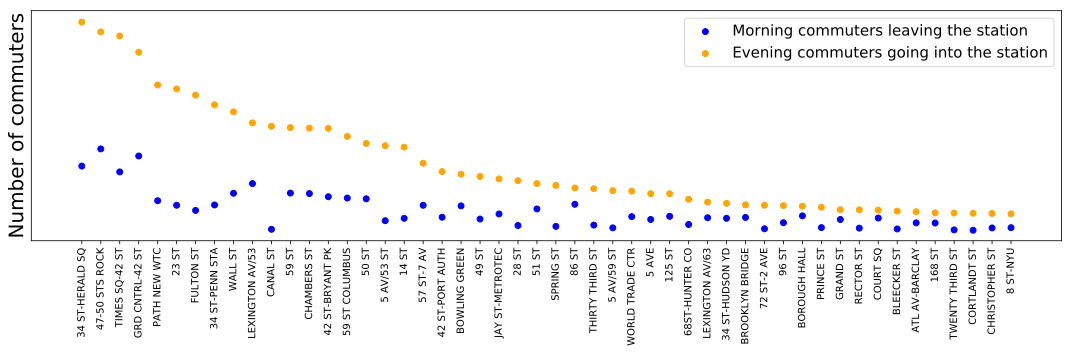

In [0]:
# final = final.reset_index()
x = temp['STATION']
y1 = temp['am_v_mid']
y2 = temp['pm_v_mid']
plt.figure(figsize=(15,5))

plt.scatter(x, y1, color = 'b')
plt.scatter(x, y2, color = 'orange')
plt.legend(['Morning commuters leaving the station','Evening commuters going into the station'],
           loc = 0, frameon = True, fontsize = 15)

ticks_y = np.linspace(0, 0, 0)
plt.yticks(ticks_y, fontsize = '10', fontname = 'Helvetica')
plt.ylabel('Number of commuters',fontsize = 20)

plt.xticks(rotation='vertical');

plt.tight_layout()


In [0]:
temp['Colors'] = temp['STATION'].isin(list(top['STATION']))
temp.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


STATION      am_exits  ...       pm_v_mid  Colors
59   34 ST-HERALD SQ  55442.807578  ...  102869.375000    True
72    47-50 STS ROCK  51222.962370  ...   98067.666667    True
350   TIMES SQ-42 ST  48419.230922  ...   96064.291667    True
232  GRD CNTRL-42 ST  68595.091792  ...   88032.436857    True
313     PATH NEW WTC  26747.574907  ...   71978.667647    True

[5 rows x 8 columns]

In [0]:
final['top10'] = True

# final2['top10'].iloc[313] = 10

final.at[313,'top10'] = False
final.at[232,'top10'] = False
final.at[59,'top10'] = False
final.at[61,'top10'] = False
final.at[350,'top10'] = False
final.at[72,'top10'] = False
final.at[225,'top10'] = False
final.at[86,'top10'] = False
final.at[68,'top10'] = False


final.head()

STATION      am_exits  ...       pm_v_mid  top10
59   34 ST-HERALD SQ  55442.807578  ...  102869.375000  False
72    47-50 STS ROCK  51222.962370  ...   98067.666667  False
350   TIMES SQ-42 ST  48419.230922  ...   96064.291667  False
232  GRD CNTRL-42 ST  68595.091792  ...   88032.436857  False
313     PATH NEW WTC  26747.574907  ...   71978.667647  False

[5 rows x 8 columns]

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


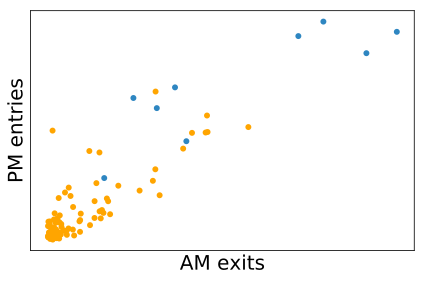

In [0]:
# Make a scatter plot to show that good commuter stations have lots of 
# relative AM exits and PM entries 

data = final[['STATION', 'am_v_mid','pm_v_mid', 'top10']].copy()

data.rename(columns = {'am_v_mid':'AM exits'}, inplace = True) 
data.rename(columns = {'pm_v_mid':'PM entries'}, inplace = True) 


x = data['AM exits']
y = data['PM entries']

flab = ["#2E86C1", "#ffa500"]
sns.set_palette(flab)
# sns.palplot(sns.color_palette())

fig = sns.scatterplot(x, y, sizes=(20, 40), linewidth=0,color = 'g', hue = 'top10', data=data, legend = False, palette = flab);


## Formatting

plt.xlabel("Values", fontsize = 15, fontname = 'Arial')
plt.xticks

ticks_y = np.linspace(0, 0, 0)
plt.yticks(ticks_y, fontsize = '10', fontname = 'Helvetica');

ticks_x = np.linspace(0, 0, 0)
plt.xticks(ticks_x, fontsize = '10', fontname = 'Helvetica');

plt.xlabel('AM exits',fontsize = 20);
plt.ylabel('PM entries',fontsize = 20);
plt.tight_layout()


#plt.ylim(0, 110000)
#plt.xlim(0, 43000);


plt.savefig('def_good_commuter_station_1.png', transparent = True, dpi = 300);

# Weekend vs. Weekday

In [0]:
df = pd.read_pickle("main.pkl")

In [0]:
df.head()

C/A  UNIT       SCP STATION  ...  ENTRIES    EXITS            DATETIME       DAY
0  A002  R051  02-00-00   59 ST  ...  7026702  2382234 2019-04-20 00:00:00  Saturday
1  A002  R051  02-00-00   59 ST  ...  7026719  2382240 2019-04-20 04:00:00  Saturday
2  A002  R051  02-00-00   59 ST  ...  7026737  2382269 2019-04-20 08:00:00  Saturday
3  A002  R051  02-00-00   59 ST  ...  7026814  2382335 2019-04-20 12:00:00  Saturday
4  A002  R051  02-00-00   59 ST  ...  7027007  2382395 2019-04-20 16:00:00  Saturday

[5 rows x 13 columns]

In [0]:
df['ENTRY COUNT'] = df.groupby(['UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff())
df['EXIT COUNT'] = df.groupby(['UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff())

df = df[(df['ENTRY COUNT'] >= 0) & (df['EXIT COUNT'] >= 0)]

df = df[(df['ENTRY COUNT'] < 15000 ) & (df['EXIT COUNT'] < 15000)]

df['VOLUME'] = df['ENTRY COUNT'] + df['EXIT COUNT']

In [0]:
weekends = df[(df.DAY == "Saturday") | (df.DAY == "Sunday")]
weekdays = df[(df.DAY != "Saturday") & (df.DAY != "Sunday")]

weekday_totals = weekdays.groupby(['STATION', 'DATE']).agg({'VOLUME' : 'sum'})
weekend_totals = weekends.groupby(['STATION', 'DATE']).agg({'VOLUME' : 'sum'})

weekday_totals.reset_index()
weekend_totals.reset_index()

weekday_average = weekday_totals.groupby('STATION').mean()
weekend_average = weekend_totals.groupby('STATION').mean()

weekday_average.reset_index()
weekend_average.reset_index()

daily_totals = weekdays.groupby('DAY').agg({'VOLUME' : 'sum'})


In [0]:
difference_ratio = weekday_average['VOLUME'] / weekend_average['VOLUME']

difference_ratio = pd.DataFrame(difference_ratio)

difference_ratio.reset_index()

difference_ratio.sort_values('VOLUME', ascending = False, inplace = True)


In [0]:
diff2 = difference_ratio.loc[list(top['STATION'])]

In [0]:
diff2

diff2.reset_index()

STATION     VOLUME
0  GRD CNTRL-42 ST   2.829094
1  34 ST-HERALD SQ   1.928631
2   34 ST-PENN STA   1.928568
3  42 ST-PORT AUTH   1.567043
4   TIMES SQ-42 ST   1.648977
5   14 ST-UNION SQ   1.732258
6   47-50 STS ROCK   3.317003
7        FULTON ST   2.838067
8   59 ST COLUMBUS   1.832470
9     PATH NEW WTC  10.325921

Text(0.5, 0, 'MTA-Wide Median = 1.96')

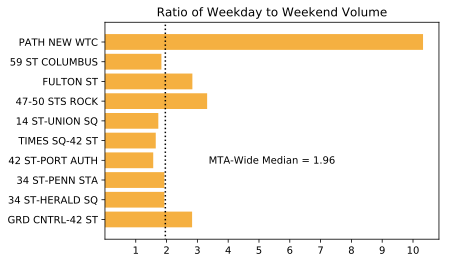

In [0]:
ticks_x = np.linspace(1,10,10)
new_x = diff2.index
new_y = diff2.VOLUME
plt.barh(new_x, new_y, color = '#F5B041')
plt.vlines(1.96,-3,15, linestyles = 'dotted')
plt.gca().set_ylim(-1, 10)
plt.xticks(ticks_x)
plt.title('Ratio of Weekday to Weekend Volume')
plt.xlabel('MTA-Wide Median = 1.96', labelpad = -100)

In [0]:
graph_weekday = weekday_average.loc[list(top['STATION'])]
graph_weekend = weekend_average.loc[list(top['STATION'])]

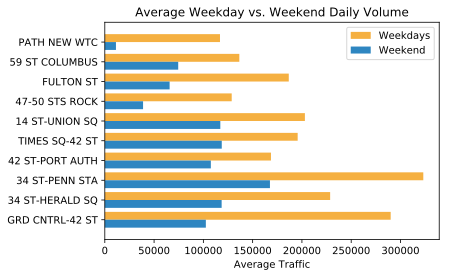

In [0]:
weekday_y = graph_weekday.VOLUME
weekday_x = graph_weekday.index
weekend_y = graph_weekend.VOLUME
weekend_x = graph_weekend.index

plt.gca().set_ylim(-1, 10)

plt.barh(weekday_x,weekday_y, height = 0.4, align = 'edge', color = '#F5B041')
plt.barh(weekend_x,weekend_y, height = -0.4, align = 'edge', color = '#2E86C1')
plt.title('Average Weekday vs. Weekend Daily Volume')
plt.xlabel('Average Traffic')
plt.legend(['Weekdays','Weekend'])

In [0]:
toplot = graph_weekday.copy()
toplot.reset_index(inplace=True)
graph_weekend.reset_index(inplace=True)
toplot.append(graph_weekend)

fin = toplot[['STATION', 'VOLUME']]
fin


STATION         VOLUME
0  GRD CNTRL-42 ST  290059.466667
1  34 ST-HERALD SQ  228641.133333
2   34 ST-PENN STA  323151.800000
3  42 ST-PORT AUTH  168597.333333
4   TIMES SQ-42 ST  195683.866667
5   14 ST-UNION SQ  203026.133333
6   47-50 STS ROCK  128762.200000
7        FULTON ST  186658.266667
8   59 ST COLUMBUS  136488.466667
9     PATH NEW WTC  116865.333333

In [0]:
len(toplot)

10

# Geolocation Data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/')

In [0]:
# geo1 = pd.read_pickle("fire.pkl")
# geo2 = pd.read_pickle("fire2.pkl")
# geo3 = pd.read_pickle("fire4.pkl")
# geo4 = pd.read_pickle("fire5.pkl")

#geo = geo1.append([geo2, geo3, geo4], sort=True)

In [0]:
locdf = pd.read_csv("http://web.mta.info/developers/data/nyct/subway/Stations.csv")
locdf.head()

Station ID  Complex ID  ...   North Direction Label South Direction Label
0           1           1  ...                     NaN             Manhattan
1           2           2  ...            Ditmars Blvd             Manhattan
2           3           3  ...  Astoria - Ditmars Blvd             Manhattan
3           4           4  ...  Astoria - Ditmars Blvd             Manhattan
4           5           5  ...  Astoria - Ditmars Blvd             Manhattan

[5 rows x 13 columns]

In [0]:
names = ['Grand Central - 42 St', 
         '34 St - Herald Sq', 
         '34 St - Penn Station', 
         '42 St - Port Authority Bus Terminal', 
         'Times Sq - 42 St',
         'Union Sq - 14 St',
         '47-50 Sts - Rockefeller Ctr',
         'Fulton St',
         '59 St - Columbus Circle',
         'World Trade Center'
         ]

In [0]:
# Data Cleaning

loc_subset = locdf[['Stop Name', 'GTFS Latitude', 'GTFS Longitude' ]]
loc_subset = loc_subset[loc_subset['Stop Name'].isin(names)]
loc_subset = loc_subset.reset_index(drop=True)

loc_subset.drop_duplicates(subset = "Stop Name", keep = 'first', inplace = True)

loc_subset


Stop Name  GTFS Latitude  GTFS Longitude
0                      Times Sq - 42 St      40.754672      -73.986754
1                     34 St - Herald Sq      40.749567      -73.987950
2                             Fulton St      40.710374      -74.007582
3                      Union Sq - 14 St      40.734789      -73.990730
4               59 St - Columbus Circle      40.768296      -73.981736
5   42 St - Port Authority Bus Terminal      40.757308      -73.989735
6                  34 St - Penn Station      40.752287      -73.993391
7                    World Trade Center      40.712582      -74.009781
9           47-50 Sts - Rockefeller Ctr      40.758663      -73.981329
16                Grand Central - 42 St      40.751776      -73.976848

In [0]:

map_osm = folium.Map(location=[40.7580, -73.9855], zoom_start=12.2)

loc_subset.apply(lambda row:folium.CircleMarker(location=[row["GTFS Latitude"], row["GTFS Longitude"]],
                                              radius=3, color='#330000', fill_color = '#1F618D')
                                             .add_to(map_osm), axis=1)

map_osm

In [0]:
tech = pd.read_csv("Tech_Companies_NYC.csv")

In [0]:
tech = tech[tech['Address'].str.len() > 5]
tech.head()

Company Name  ... URL
9       10 Speed Labs'  ... NaN
17  1800Postcards.com'  ... NaN
20          1938 News'  ... NaN
21            1DocWay'  ... NaN
27        1stdibs.com'  ... NaN

[5 rows x 6 columns]

In [0]:
tech['Final'] = tech['Address'].map(str) + ', New York'
tech['Final'] = tech['Final'].str.replace("'", "")

tech.head()

Company Name  ...                                              Final
9       10 Speed Labs'  ...                            1239 Broadway, New York
17  1800Postcards.com'  ...                        121 Varick Street, New York
20          1938 News'  ...                               1 Astor Pl, New York
21            1DocWay'  ...  483 Broadway, Floor 2, New York, NY 10013, New...
27        1stdibs.com'  ...                           51 Astor Place, New York

[5 rows x 7 columns]

In [0]:
tech.head()
fire = tech.sample(100, random_state=95)
#fire = tech.sample(100, random_state=18)

In [0]:
from geopy.geocoders import Nominatim

In [0]:
geolocator = Nominatim(user_agent="TechLoc5")

In [0]:
#fire['city_coord'] = fire['Final'].apply(geolocator.geocode)
#fire.dropna(subset=['city_coord'], inplace=True)

#fire['lat'] = fire['city_coord'].apply(lambda x: (x.latitude))
#fire['long'] = fire['city_coord'].apply(lambda x: (x.longitude))

In [0]:
geos = pd.read_pickle('fire9.pkl')

In [0]:
geos.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]],tiles="Mapbox Bright", 
                                              radius=1, color='#27AE60')
                                             .add_to(map_osm), axis=1)

map_osm

In [0]:
m = folium.Map(location=[40.7580, -73.9855], tiles="Mapbox Bright", zoom_start=2)


for i in range(0,len(geos)):
    folium.Marker([geos.iloc[i]['long'], geos.iloc[i]['lat']]).add_to(m)



In [0]:
len(geos)

412

In [0]:
top

STATION      LINENAME  ENTRY COUNT  EXIT COUNT  TOTAL TRAFFIC
311  GRD CNTRL-42 ST         4567S    2639828.0   2326228.0      4966056.0
89   34 ST-HERALD SQ      BDFMNQRW    2129151.0   2011772.0      4140923.0
93    34 ST-PENN STA           ACE    1527514.0   1383212.0      2910726.0
102  42 ST-PORT AUTH  ACENQRS1237W    1439824.0   1209977.0      2649801.0
446   TIMES SQ-42 ST  1237ACENQRSW    1261544.0   1207689.0      2469233.0
27    14 ST-UNION SQ      LNQR456W    1330276.0   1199564.0      2529840.0
106   47-50 STS ROCK          BDFM    1064730.0   1099616.0      2164346.0
301        FULTON ST      2345ACJZ    1103759.0   1089165.0      2192924.0
125   59 ST COLUMBUS         ABCD1    1099081.0    908617.0      2007698.0
402     PATH NEW WTC             1     956183.0    864703.0      1820886.0

Text(0.5, 1.0, 'Top 10 Stations')

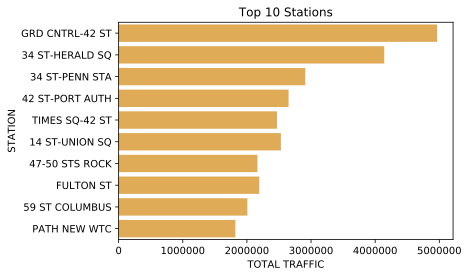

In [0]:
sns.barplot(x='TOTAL TRAFFIC', y='STATION', data=top, color='#F5B041').set_title('Top 10 Stations')
